# Лабораторная работа: обработка изображений (фильтры, пороги, контуры, сегментация)

**Требования:** `opencv-python`, `numpy`, `matplotlib`, `scikit-image`, `pillow`.


## Установка зависимостей (при необходимости)


In [126]:
# Установка зависимостей
# ВЫПОЛНЯТЬ ТОЛЬКО ПРИ НЕОБХОДИМОСТИ
# !pip install opencv-python pillow matplotlib scikit-image numpy
pass


## Импорт библиотек и вспомогательные функции

Функции чтения/показа изображений, утилиты.

In [149]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, morphology

from typing import Any, Tuple, cast, Callable, Dict, Iterable, List, Optional
import numpy as np
from skimage import exposure

import os
from dataclasses import dataclass
from pathlib import Path



plt.rcParams['figure.figsize'] = (8, 6)

def imread_rgb(path):
    bgr = cv2.imread(path)
    if bgr is None:
        raise FileNotFoundError(f"Не могу открыть файл: {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def show(img, title=None):
    plt.figure()
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()


## Загрузка исходного изображения


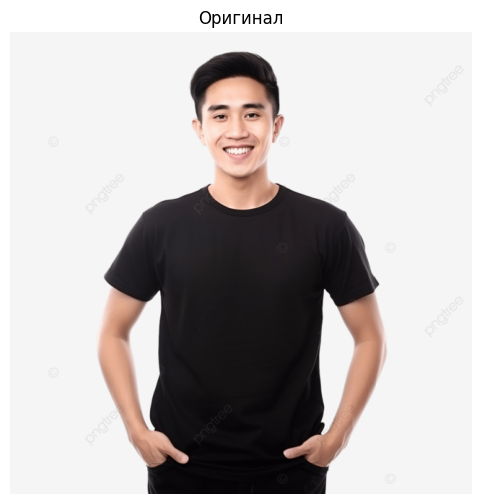

In [128]:
# Загрузка изображения
# Считывает изображение и показывает его.
IMG_PATH = "Nekit.png"
img = imread_rgb(IMG_PATH)
show(img, "Оригинал")


## Фильтры как в телефоне

Градации серого, размытие, резкость, гамма/контраст, тёплый тон, виньетка.

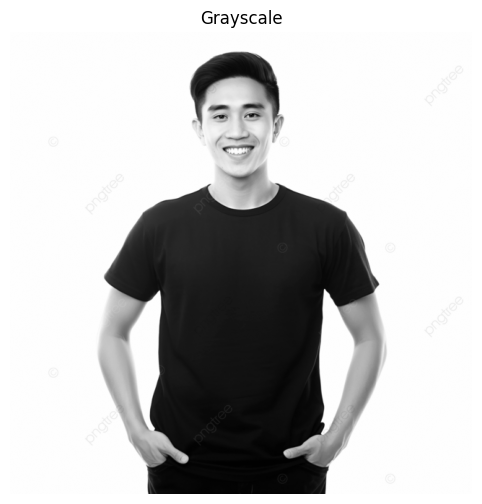

In [129]:
# Градации серого
# Преобразует изображение к оттенкам серого.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
show(gray, "Grayscale")


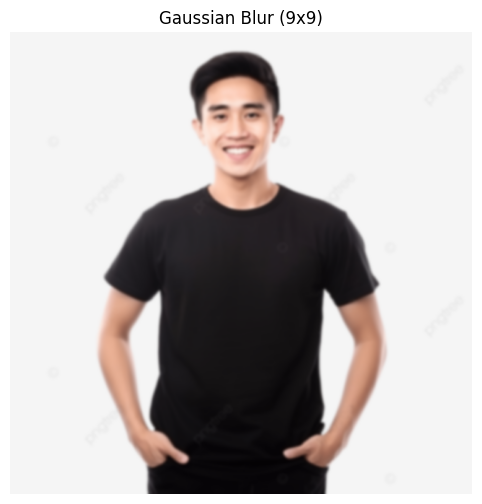

In [130]:
# Gaussian Blur (размытие)
# Усредняет шум и сглаживает детали.
blur = cv2.GaussianBlur(img, (9, 9), 0)
show(blur, "Gaussian Blur (9x9)")


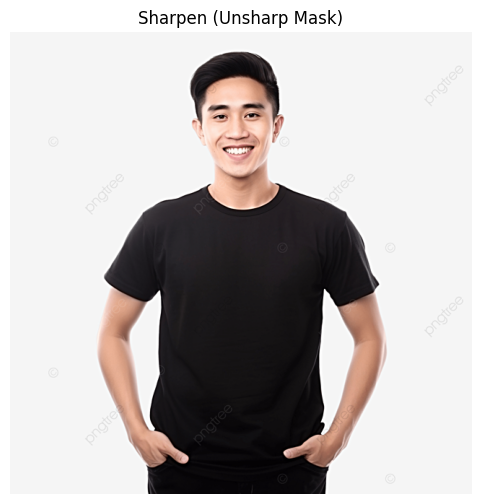

In [131]:
# Резкость (Unsharp Mask)
# Увеличивает локальный контраст и резкость.
sharp = cv2.addWeighted(img, 1.5, cv2.GaussianBlur(img, (0,0), 2), -0.5, 0)
show(sharp, "Sharpen (Unsharp Mask)")


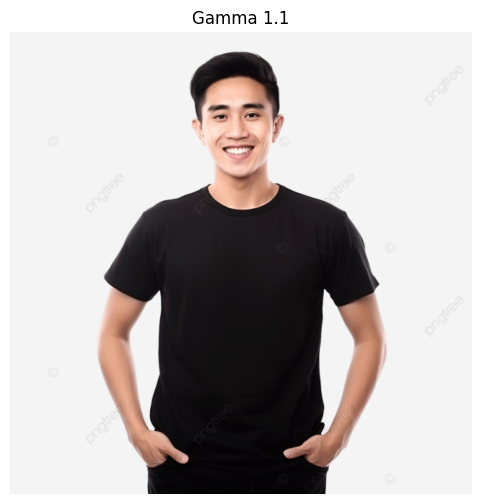

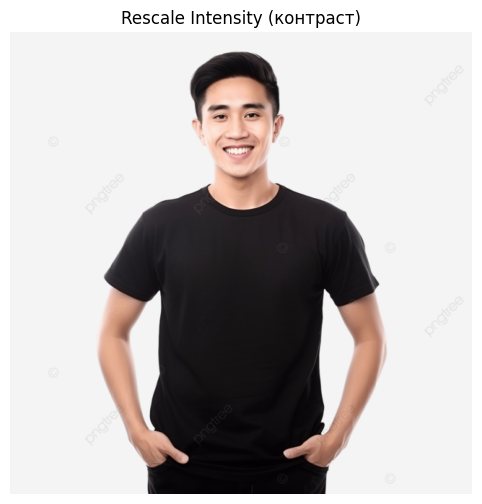

In [132]:
# Эффект и контраст
# Коррекция гаммы и диапазона.

gamma_value: float = 1.1  # >1 затемняет, <1 светлит
gamma_corr = exposure.adjust_gamma(img, gamma=cast(Any, gamma_value))
show(gamma_corr, f"Gamma {gamma_value}")

out_range: Tuple[int, int] = (0, 255)
contrast = exposure.rescale_intensity(
    img,
    in_range="image",
    out_range=cast(Any, out_range),
).astype(np.uint8)
show(contrast, "Rescale Intensity (контраст)")



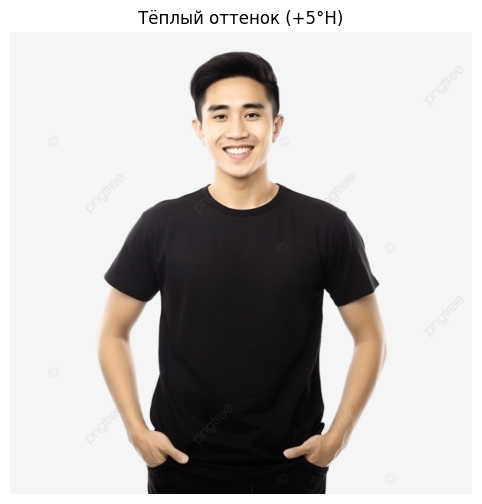

In [133]:
# Тёплый оттенок (HSV hue shift)
# Добавляет тёплый тон путем смещения оттенка в HSV.
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
hsv[...,0] = (hsv[...,0] + 5) % 180   # слегка теплее
warm = cv2.cvtColor(np.clip(hsv,0,255).astype(np.uint8), cv2.COLOR_HSV2RGB)
show(warm, "Тёплый оттенок (+5°H)")


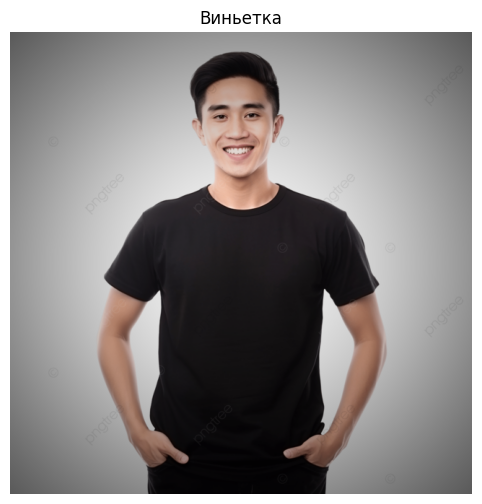

In [134]:
# Лёгкая виньетка
# Добавляет затемнение к краям изображения.
rows, cols = img.shape[:2]
X = cv2.getGaussianKernel(cols, cols/2)
Y = cv2.getGaussianKernel(rows, rows/2)
mask = (Y @ X.T)
mask = (mask / mask.max())
vignette = np.uint8(img * mask[...,None])
show(vignette, "Виньетка")


## Отражение (flip) и поворот

Горизонтальное/вертикальное отражение и поворот на 45°.

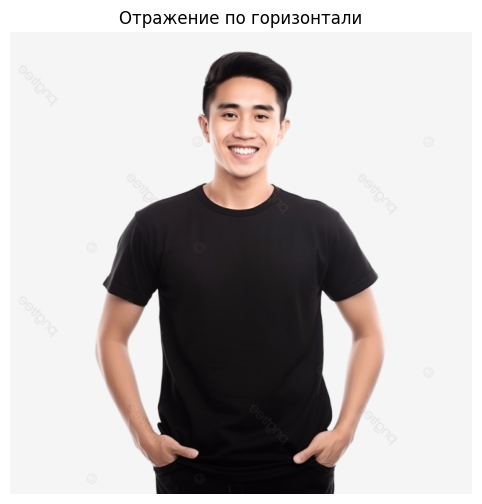

In [135]:
# Отражение по горизонтали
# Зеркальное отражение относительно вертикальной оси.
flip_h = cv2.flip(img, 1)
show(flip_h, "Отражение по горизонтали")


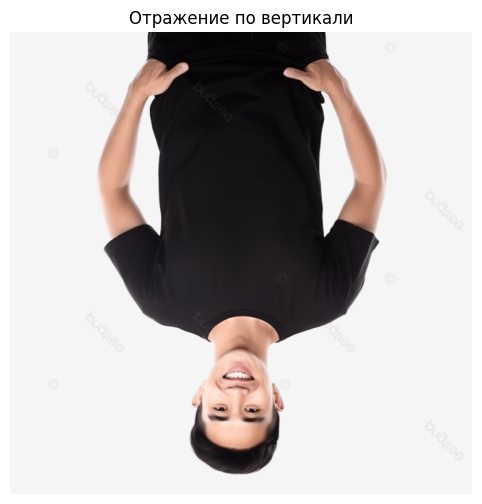

In [136]:
# Отражение по вертикали
# Зеркальное отражение относительно горизонтальной оси.
flip_v = cv2.flip(img, 0)
show(flip_v, "Отражение по вертикали")


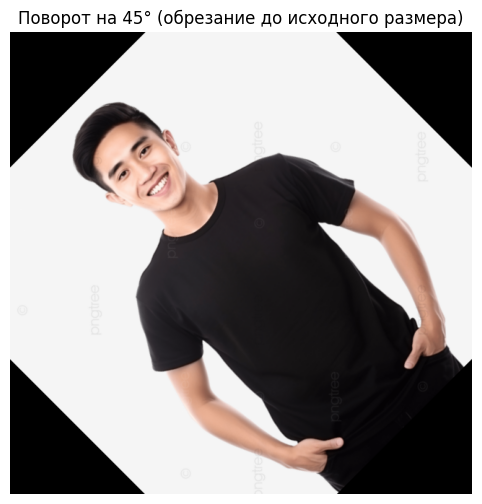

In [137]:
# Поворот на 45° (с обрезанием до исходного размера)
# Поворачивает изображение на 45° и сохраняет исходный размер кадра (часть изображения будет обрезана по краям).
h, w = img.shape[:2]
center = (w/2, h/2)
angle = 45
scale = 1.0
M = cv2.getRotationMatrix2D(center, angle, scale)

# Поворачиваем и сохраняем исходный размер (w, h); края выходят за рамки и обрезаются
rot45_crop = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
show(rot45_crop, "Поворот на 45° (обрезание до исходного размера)")


## Пороговая обработка (глобальная и адаптивная)

Глобальный порог (в т.ч. Otsu) и адаптивный порог (mean/gaussian).

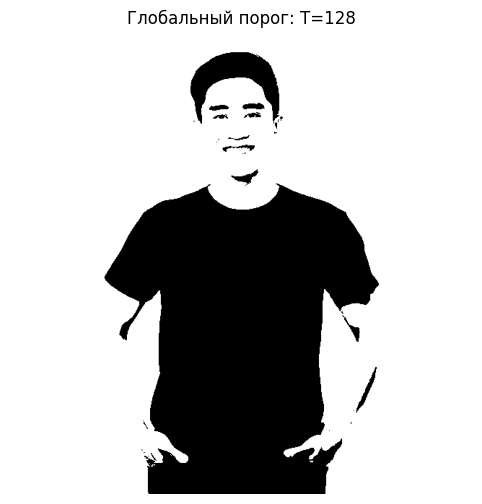

In [138]:
# Глобальный порог (ручной)
# Пороговая бинаризация с фиксированным значением T.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
T = 128  # измените по необходимости
_, th_manual = cv2.threshold(gray, T, 255, cv2.THRESH_BINARY)
show(th_manual, f"Глобальный порог: T={T}")


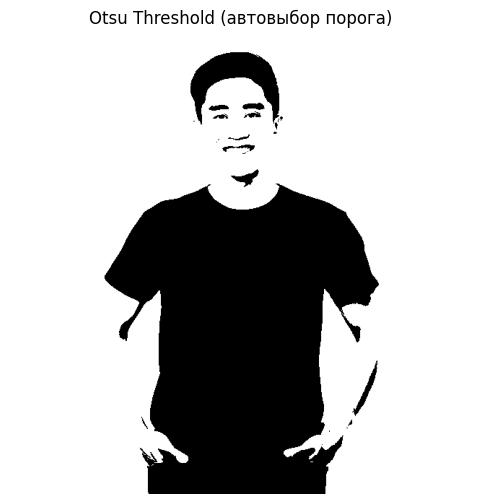

In [139]:
# Глобальный порог Otsu
# Автоматический выбор порога методом Отсу.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
_, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show(th_otsu, "Otsu Threshold (автовыбор порога)")


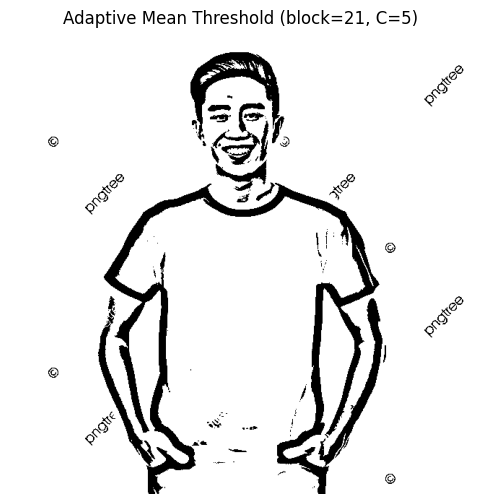

In [140]:
# Адаптивный порог (средний)
# Адаптивная бинаризация по среднему в локальном окне.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
th_mean = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, blockSize=21, C=5)
show(th_mean, "Adaptive Mean Threshold (block=21, C=5)")


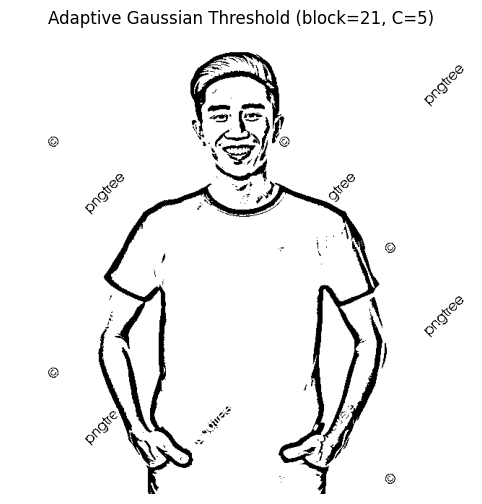

In [141]:
# Адаптивный порог (гауссовый)
# Адаптивная бинаризация с весами Гаусса в окрестности.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
th_gauss = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, blockSize=21, C=5)
show(th_gauss, "Adaptive Gaussian Threshold (block=21, C=5)")


## Обводка контура объекта (Canny + контур)

Выделяем контуры и рисуем самый большой контур поверх изображения.

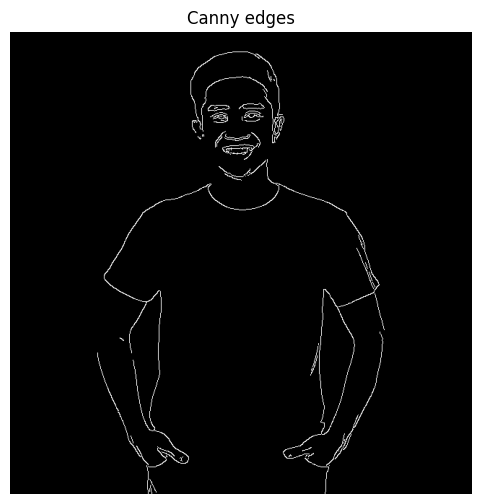

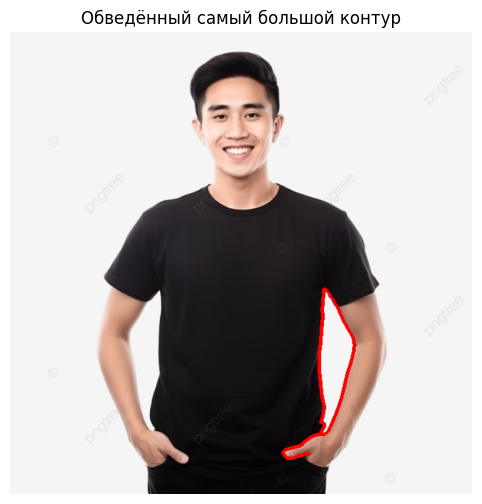

In [142]:
# Canny и обводка большого контура
# Находит внешние контуры и рисует самый крупный на копии изображения.
edges = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 100, 200)
show(edges, "Canny edges")

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
overlay = img.copy()
if contours:
    c = max(contours, key=cv2.contourArea)
    cv2.drawContours(overlay, [c], -1, (255, 0, 0), 3)
    show(overlay, "Обведённый самый большой контур")
else:
    print("Контуры не найдены — подберите пороги Canny или добавьте размытие.")


## Отделение объекта (GrabCut)

Полуавтоматическая сегментация по прямоугольнику; сохраняем PNG с прозрачным фоном.

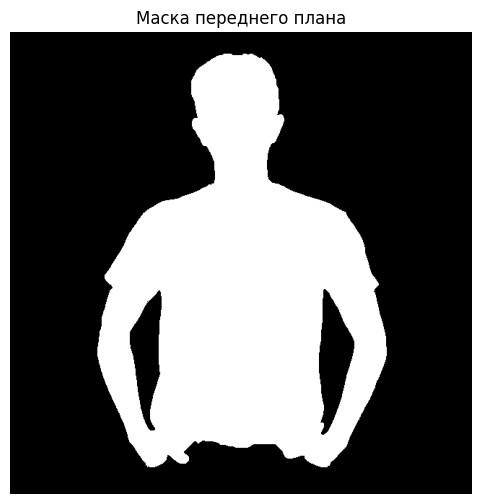

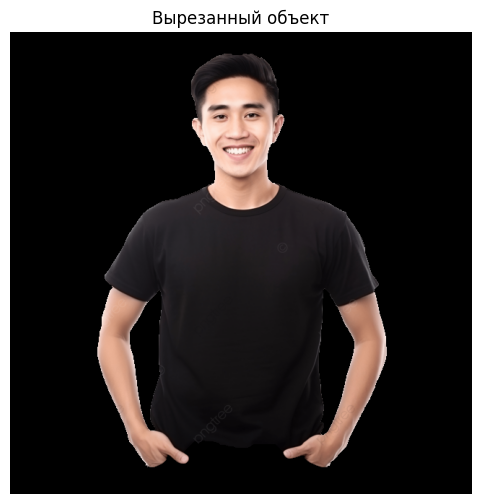

In [143]:
# GrabCut (прямоугольник) + сохранение PNG
# Вырезает объект в прямоугольнике и сохраняет PNG с альфа-каналом.
rect = (30, 30, img.shape[1]-60, img.shape[0]-60)  # подстройте под вашу сцену

mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

cv2.grabCut(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask_fg = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
cutout = (img * mask_fg[...,None]).astype(np.uint8)
show(mask_fg*255, "Маска переднего плана")
show(cutout, "Вырезанный объект")

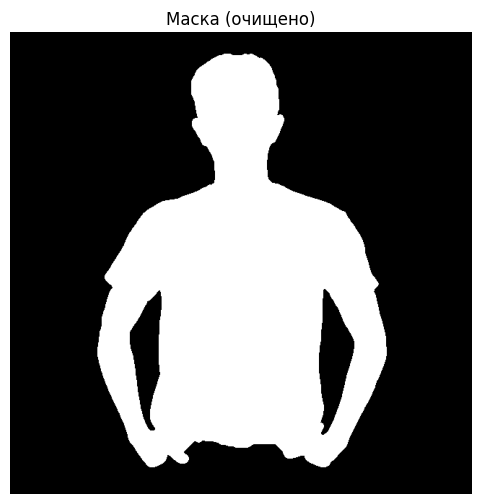

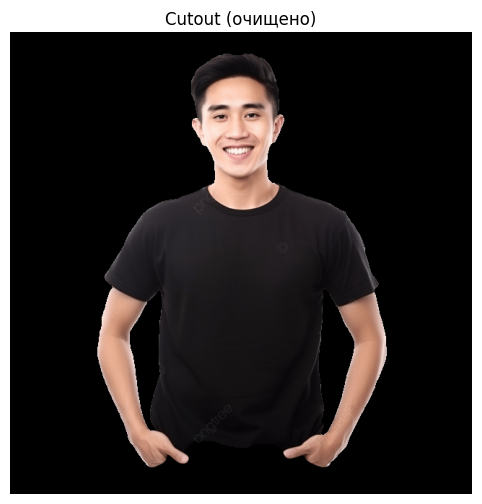

In [144]:
# Очистка маски морфологией (опционально)
# Чистит маску от шумов и мелких артефактов.
mask_clean = morphology.opening(mask_fg, morphology.disk(3))
# Удаление мелких дыр и объектов
mask_clean = morphology.remove_small_holes(mask_clean.astype(bool), area_threshold=200).astype(np.uint8)
mask_clean = morphology.remove_small_objects(mask_clean.astype(bool), min_size=300).astype(np.uint8)

cutout_clean = (img * mask_clean[...,None]).astype(np.uint8)
show(mask_clean*255, "Маска (очищено)")
show(cutout_clean, "Cutout (очищено)")


## Быстрая цветовая сегментация (K-Means)

Разбиение на кластеры цветов и эвристический выбор кластера объекта.

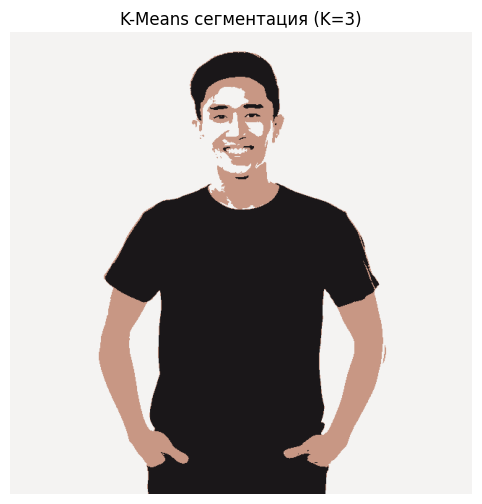

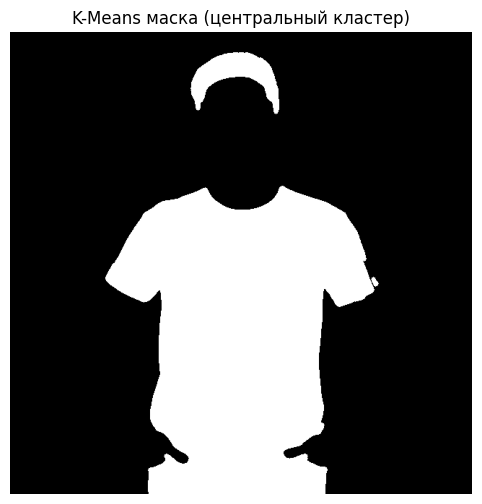

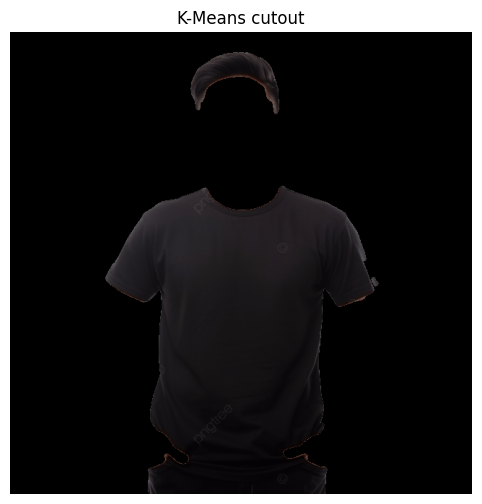

In [145]:
# K-Means сегментация и cutout
# Кластеризация по цвету и выделение центрального кластера.
Z = img.reshape((-1, 3)).astype(np.float32)
K = 3  # число кластеров
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
best_labels = np.zeros((Z.shape[0], 1), dtype=np.int32)
ret, label, center = cv2.kmeans(Z, K, best_labels, criteria, 10, cv2.KMEANS_PP_CENTERS)
center = center.astype(np.uint8)
segmented = center[label.flatten()].reshape(img.shape)
show(segmented, f"K-Means сегментация (K={K})")

h, w = img.shape[:2]
cy0, cy1, cx0, cx1 = h // 4, 3 * h // 4, w // 4, 3 * w // 4
central_labels = label.reshape(h, w)[cy0:cy1, cx0:cx1]
target_cluster = np.bincount(central_labels.flatten()).argmax()

km_mask = (label.reshape(h, w) == target_cluster).astype(np.uint8)
km_mask = morphology.opening(km_mask, morphology.disk(3))
km_cut = (img * km_mask[..., None]).astype(np.uint8)
show(km_mask * 255, "K-Means маска (центральный кластер)")
show(km_cut, "K-Means cutout")


## Ровная обводка найденной области (аппроксимация)

Аппроксимация контура полилинией для аккуратной обводки.

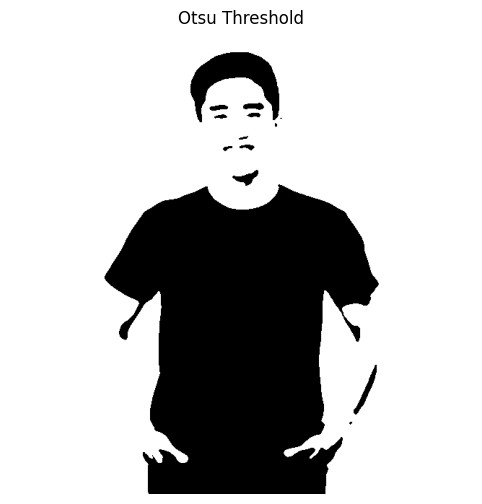

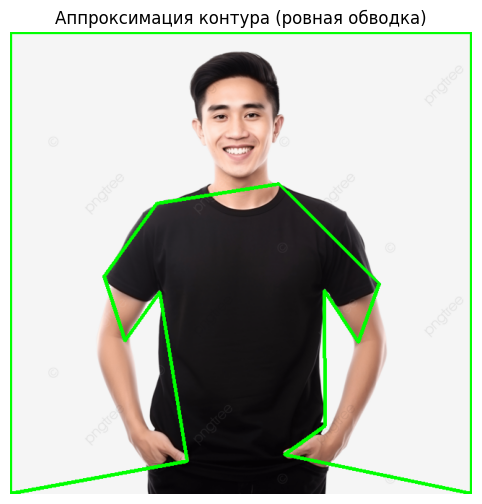

In [146]:
# Аппроксимация контура (polyDP)
# Строит замкнутую полилинию по крупнейшему контуру и рисует её.
thr = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_OTSU)[1]
thr = cv2.medianBlur(thr, 5)
contours, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    c = max(contours, key=cv2.contourArea)
    eps = 0.01 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, eps, True)

    outlined = img.copy()
    cv2.polylines(outlined, [approx], True, (0,255,0), 3)
    show(thr, "Otsu Threshold")
    show(outlined, "Аппроксимация контура (ровная обводка)")
else:
    print("Контуры не найдены на бинаризованном изображении.")


## Генератор датасета футболки

В этом разделе собраны функции для автоматической генерации пар изображение/маска для футболки. Полученный набор позже используем в задаче сегментации.

In [150]:
@dataclass(frozen=True)
class TShirtSample:
    """Единичный пример (изображение и маска футболки)."""

    image: np.ndarray
    mask: np.ndarray
    tag: str


def _ensure_uint8(mask: np.ndarray) -> np.ndarray:
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    if mask.max() <= 1:
        mask = mask * 255
    return mask


def grabcut_person_mask(image_rgb: np.ndarray, rect_margin: int = 30, iter_count: int = 5) -> np.ndarray:
    h, w = image_rgb.shape[:2]
    rect = (
        rect_margin,
        rect_margin,
        max(1, w - 2 * rect_margin),
        max(1, h - 2 * rect_margin),
    )

    mask = np.zeros((h, w), np.uint8)
    bg_model = np.zeros((1, 65), np.float64)
    fg_model = np.zeros((1, 65), np.float64)

    cv2.grabCut(
        cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR),
        mask,
        rect,
        bg_model,
        fg_model,
        iter_count,
        cv2.GC_INIT_WITH_RECT,
    )

    return np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)


def extract_tshirt_mask(
    image_rgb: np.ndarray,
    person_mask: Optional[np.ndarray] = None,
    torso_top: float = 0.32,
    torso_bottom: float = 0.82,
    k_clusters: int = 3,
    morph_kernel: int = 9,
) -> np.ndarray:
    if person_mask is None:
        person_mask = grabcut_person_mask(image_rgb)

    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    h, w = lab.shape[:2]

    flat_mask = person_mask.flatten().astype(bool)
    lab_pixels = lab.reshape(-1, 3)[flat_mask]
    if lab_pixels.size == 0:
        raise ValueError("Mask contains no foreground pixels.")

    lab_samples = lab_pixels.astype(np.float32)
    best_labels = np.zeros((lab_samples.shape[0], 1), dtype=np.int32)

    _, labels, centers = cv2.kmeans(
        lab_samples,
        min(max(2, k_clusters), lab_samples.shape[0]),
        best_labels,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40, 0.1),
        8,
        cv2.KMEANS_PP_CENTERS,
    )

    label_map = np.full(flat_mask.shape, -1, dtype=np.int32)
    label_map[flat_mask] = labels.flatten()
    label_map = label_map.reshape(h, w)

    top = int(h * torso_top)
    bottom = int(h * torso_bottom)
    torso_roi = np.zeros_like(person_mask, dtype=bool)
    torso_roi[top:bottom, :] = True

    center_top = int(h * ((torso_top + torso_bottom) / 2 - 0.1))
    center_bottom = int(h * ((torso_top + torso_bottom) / 2 + 0.1))
    center_left = int(w * 0.25)
    center_right = int(w * 0.75)
    seed_roi = np.zeros_like(person_mask, dtype=bool)
    seed_roi[max(0, center_top):min(h, center_bottom), max(0, center_left):min(w, center_right)] = True

    seed_mask = seed_roi & person_mask.astype(bool)
    seed_pixels = lab.reshape(-1, 3)[seed_mask.flatten()]
    if seed_pixels.size == 0:
        seed_pixels = lab_pixels
    seed_mean = seed_pixels.mean(axis=0)

    scores: List[Tuple[float, int, int]] = []
    for cluster_id in range(centers.shape[0]):
        cluster_mask = (label_map == cluster_id) & torso_roi
        area = int(cluster_mask.sum())
        color_distance = float(np.linalg.norm(centers[cluster_id] - seed_mean))
        scores.append((color_distance, -area, cluster_id))

    _, _, best_cluster = min(scores)
    tshirt_mask = ((label_map == best_cluster) & torso_roi).astype(np.uint8)

    kernel = np.ones((morph_kernel, morph_kernel), np.uint8)
    tshirt_mask = cv2.morphologyEx(tshirt_mask, cv2.MORPH_CLOSE, kernel)
    small_kernel_size = max(1, morph_kernel // 2)
    small_kernel = np.ones((small_kernel_size, small_kernel_size), np.uint8)
    tshirt_mask = cv2.morphologyEx(tshirt_mask, cv2.MORPH_OPEN, small_kernel)

    if tshirt_mask.any():
        _, comp_labels = cv2.connectedComponents(tshirt_mask)
        areas = [
            (comp_labels == label).sum()
            for label in range(1, comp_labels.max() + 1)
        ]
        if areas:
            best_label = int(np.argmax(areas)) + 1
            tshirt_mask = (comp_labels == best_label).astype(np.uint8)

    tshirt_mask = tshirt_mask * person_mask.astype(np.uint8)
    return (tshirt_mask > 0).astype(np.uint8)


def _rotate(image: np.ndarray, mask: np.ndarray, angle: float) -> Tuple[np.ndarray, np.ndarray]:
    h, w = image.shape[:2]
    center = (w / 2.0, h / 2.0)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_img = cv2.warpAffine(
        image,
        matrix,
        (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REFLECT,
    )
    rotated_mask = cv2.warpAffine(
        _ensure_uint8(mask),
        matrix,
        (w, h),
        flags=cv2.INTER_NEAREST,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0,
    )
    return rotated_img, (rotated_mask > 127).astype(np.uint8)


def default_augmentations() -> Dict[str, Callable[[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]]:
    def identity(img, msk):
        return img, msk

    def flip_h(img, msk):
        return np.ascontiguousarray(img[:, ::-1]), np.ascontiguousarray(msk[:, ::-1])

    def flip_v(img, msk):
        return np.ascontiguousarray(img[::-1, :]), np.ascontiguousarray(msk[::-1, :])

    def rot_m15(img, msk):
        return _rotate(img, msk, -15)

    def rot_p15(img, msk):
        return _rotate(img, msk, 15)

    return {
        "orig": identity,
        "flip_h": flip_h,
        "flip_v": flip_v,
        "rot_m15": rot_m15,
        "rot_p15": rot_p15,
    }


def generate_tshirt_samples(
    image_rgb: np.ndarray,
    augmentations: Optional[Dict[str, Callable[[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]]] = None,
    person_mask: Optional[np.ndarray] = None,
) -> List[TShirtSample]:
    if augmentations is None:
        augmentations = default_augmentations()
    if person_mask is None:
        person_mask = grabcut_person_mask(image_rgb)

    tshirt_mask = extract_tshirt_mask(image_rgb, person_mask=person_mask)
    samples: List[TShirtSample] = []
    for tag, transform in augmentations.items():
        aug_img, aug_mask = transform(image_rgb, tshirt_mask)
        samples.append(
            TShirtSample(
                image=np.ascontiguousarray(aug_img, dtype=np.uint8),
                mask=np.ascontiguousarray(aug_mask, dtype=np.uint8),
                tag=tag,
            )
        )
    return samples


def save_samples(samples: Iterable[TShirtSample], output_dir: os.PathLike, prefix: str = "sample") -> None:
    output_dir = Path(output_dir)
    img_dir = output_dir / "images"
    mask_dir = output_dir / "masks"
    img_dir.mkdir(parents=True, exist_ok=True)
    mask_dir.mkdir(parents=True, exist_ok=True)

    for idx, sample in enumerate(samples, start=1):
        img_path = img_dir / f"{prefix}_{idx:02d}_{sample.tag}.png"
        mask_path = mask_dir / f"{prefix}_{idx:02d}_{sample.tag}.png"
        cv2.imwrite(str(img_path), cv2.cvtColor(sample.image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(str(mask_path), _ensure_uint8(sample.mask))


Сохранено 5 вариантов в C:\VsCode\ML_labs\ImageSegmentation_Lab2\dataset_tshirt


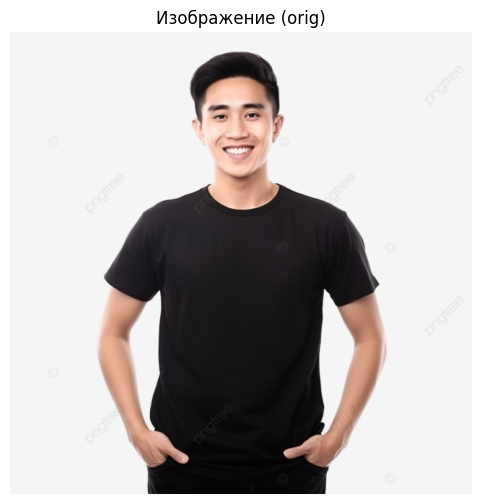

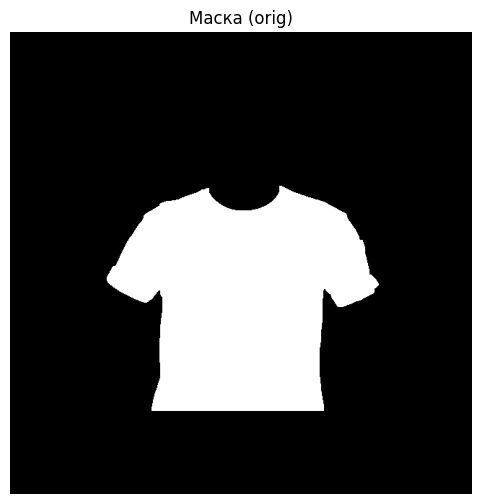

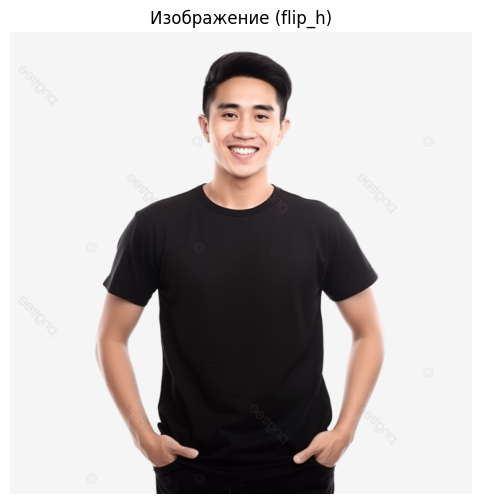

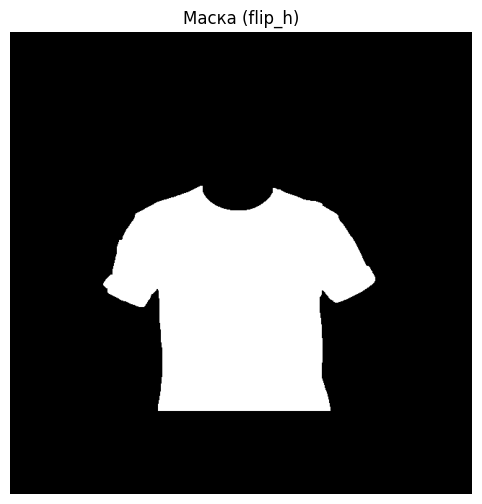

In [ ]:
dataset_dir = Path("../ImageSegmentation_Lab2/dataset_tshirt")

person_mask = grabcut_person_mask(img, rect_margin=25)
samples = generate_tshirt_samples(
    img,
    augmentations=default_augmentations(),
    person_mask=person_mask,
)

save_samples(samples, dataset_dir, prefix="nekit")

print(f"Сохранено {len(samples)} вариантов в {dataset_dir.resolve()}")

for preview in samples[:2]:
    show(preview.image, f"Изображение ({preview.tag})")
    show(preview.mask * 255, f"Маска ({preview.tag})")


В ходе выполнения лабораторной работы была изучена и реализована обработка изображений средствами библиотеки **OpenCV** и сопутствующих инструментов Python.  

Были освоены и применены следующие методы:

1. **Базовые фильтры и преобразования:**  
   - преобразование в оттенки серого, размытие (Gaussian Blur), повышение резкости;  
   - корректировка яркости и контраста (gamma, rescale intensity);  
   - применение цветовых фильтров (тёплый оттенок) и эффектов (виньетка).

2. **Геометрические преобразования:**  
   - отражение изображения по горизонтали и вертикали;  
   - поворот изображения на 45° с обрезанием до исходного размера;  
   - автоматическое кадрирование для удаления чёрных углов.

3. **Пороговая обработка:**  
   - глобальный и адаптивный пороги (в том числе метод Отсу);  
   - использование бинаризации для последующего выделения контуров.

4. **Выделение и сегментация объектов:**  
   - нахождение и обводка контуров с помощью оператора **Canny**;  
   - выделение основного объекта методом **GrabCut**, в том числе ускоренная и улучшенная версии с подсказками (человек как foreground);  
   - цветовая сегментация изображения с использованием **K-Means** кластеризации.

5. **Постобработка:**  
   - морфологическая очистка масок от шумов;  
   - сохранение вырезанного объекта в формате **PNG** с прозрачным фоном.

---

**Результаты:**  
Полученные изображения подтверждают корректность реализации каждого метода. Ускоренная и улучшенная версии алгоритма GrabCut позволили добиться качественного выделения человека на фоне сложной сцены (башни), при этом существенно сократив время вычислений.  

Таким образом, цель лабораторной работы — **изучение и практическое применение методов обработки и сегментации изображений в Python** — достигнута. Были закреплены навыки работы с OpenCV, а также понимание принципов фильтрации, пороговой обработки и выделения объектов.